# Setup

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

### Prepare the datasets

In [2]:
CLASSES = ['Corrosionstain', 'Cracks', 'Spalling']

TRAIN_DIR = "BiNet_Dataset/training"
VAL_DIR = "BiNet_Dataset/validation"
TEST_DIR = "BiNet_Dataset/testing"

### Set GPU memory growth

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Create Generators

In [10]:
augment_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

scale_gen = ImageDataGenerator(
    rescale=1.0/255,
)

Added augmentation to the training set

In [12]:
IMG_WIDTH = IMG_HEIGHT = 256 
BATCH_SIZE = 64 

train_generator = augment_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = scale_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = scale_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2428 images belonging to 3 classes.
Found 347 images belonging to 3 classes.
Found 696 images belonging to 3 classes.


# Model Training

### Create Model

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Model Summary

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,771 (56.61 MB)

 Trainable params: 14,840,067 (56.61 MB)

 Non-trainable params: 704 (2.75 KB)

### Fit Model

In [15]:
model_hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20 
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 690ms/step - accuracy: 0.5152 - loss: 1.4485 - val_accuracy: 0.3833 - val_loss: 2.1081
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 611ms/step - accuracy: 0.6133 - loss: 0.9750 - val_accuracy: 0.3833 - val_loss: 2.6864
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 666ms/step - accuracy: 0.6538 - loss: 0.8838 - val_accuracy: 0.3833 - val_loss: 3.3307
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 645ms/step - accuracy: 0.7253 - loss: 0.7680 - val_accuracy: 0.3833 - val_loss: 3.4311
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 618ms/step - accuracy: 0.7282 - loss: 0.6937 - val_accuracy: 0.3833 - val_loss: 4.0070
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 638ms/step - accuracy: 0.7510 - loss: 0.6788 - val_accuracy: 0.3833 - val_loss: 4.1923
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 652ms/step - accuracy: 0.7584 - loss: 0.6602 - val_accuracy: 0.3833 - val_loss: 3.7794
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 614ms/step - accuracy: 0.7714 - loss: 0.6178 - val_accu

# Model Evaluation

### Evaluate the training and validation data

In [29]:
def plot_training_history(history):
    """
    Plot the training history of the model using Seaborn.

    Parameters:
    - history: History object containing the training history.

    Returns:
    - None (displays the plots)
    """
    
    # Extracting data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Creating DataFrames for plotting
    epochs = range(1, len(acc) + 1)
    
    # Data for accuracy
    acc_data = {
        'Epoch': list(epochs) * 2,
        'Value': acc + val_acc,
        'Metric': ['Training Accuracy'] * len(acc) + ['Validation Accuracy'] * len(val_acc)
    }
    acc_df = pd.DataFrame(acc_data)

    # Data for loss
    loss_data = {
        'Epoch': list(epochs) * 2,
        'Value': loss + val_loss,
        'Metric': ['Training Loss'] * len(loss) + ['Validation Loss'] * len(val_loss)
    }
    loss_df = pd.DataFrame(loss_data)

    # Creating side-by-side plots
    plt.figure(figsize=(12, 4))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(data=acc_df, x='Epoch', y='Value', hue='Metric', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(data=loss_df, x='Epoch', y='Value', hue='Metric', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

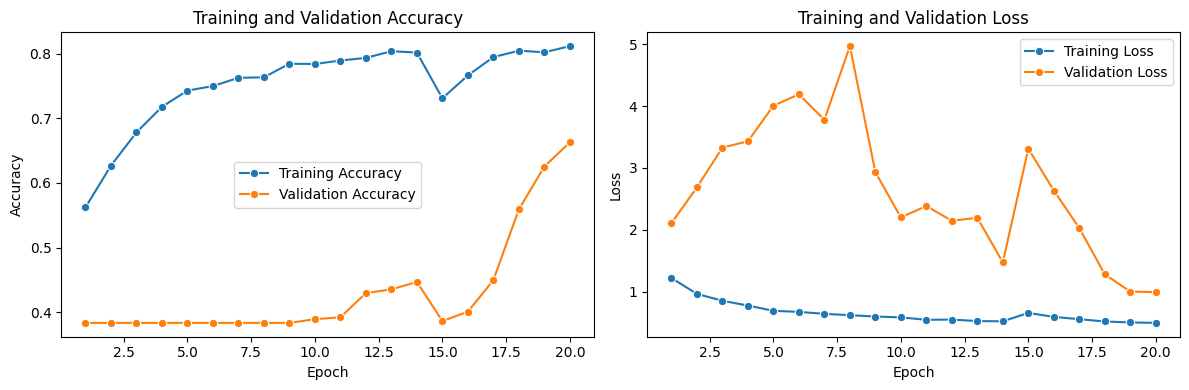

In [30]:
plot_training_history(model_hist)

### Evaluate the test data

In [31]:
model.evaluate(test_generator)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.8408 - loss: 0.4635


[0.9074965119361877, 0.6982758641242981]

### Create dataframe of the testing data

In [32]:
def create_evaluation_dataframe(model, test_generator, classes):
    """
    Creates a DataFrame summarizing the model's performance on the test data.

    Parameters:
    - model: Trained Keras model for predictions.
    - test_generator: A Keras ImageDataGenerator iterator for the test set.
    - classes: List of class names corresponding to the model's output.

    Returns:
    - DataFrame containing filenames, true labels, predicted labels, prediction confidence, and correctness.
    """
    # Get all images and labels from the test generator
    test_generator.reset()  # Reset the generator to ensure we process all test data
    filenames = test_generator.filenames
    true_labels_one_hot = test_generator.classes  # Class indices for true labels

    # Predict the labels for the entire test set
    predictions = model.predict(test_generator, verbose=1)
    predicted_labels_indices = np.argmax(predictions, axis=1)  # Class indices for predictions
    prediction_confidences = np.max(predictions, axis=1)  # Max confidence for each prediction

    # Map indices to class names
    true_labels_names = [classes[idx] for idx in true_labels_one_hot]
    predicted_labels_names = [classes[idx] for idx in predicted_labels_indices]

    # Determine correctness
    correct_predictions = (predicted_labels_indices == true_labels_one_hot)

    # Create the DataFrame
    df = pd.DataFrame({
        "Filename": filenames,
        "Damage Type": true_labels_names,
        "Prediction": predicted_labels_names,
        "Prediction Confidence": prediction_confidences,
        "Correct Prediction": correct_predictions
    })

    return df


In [33]:
eval_df = create_evaluation_dataframe(model, test_generator, CLASSES)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step


### Check the average prediction confidence

In [34]:
def plot_average_confidence(eval_df):
    """
    Plot average confidence for each class.
    Parameters:
    - eval_df: DataFrame containing evaluation results.
    
    Returns:
    - None (displays the plot)
    """
    
    # Calculate average confidence
    average_confidence = eval_df.groupby('Prediction')['Prediction Confidence'].mean().reset_index()
    average_confidence.columns = ['Prediction', 'Average Confidence']
    
    # Create a bar plot with hue set to 'Prediction' and legend turned off
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Prediction', y='Average Confidence', data=average_confidence, hue='Prediction', palette='viridis', legend=False)
    plt.title('Average Confidence by Prediction')
    plt.xlabel('Prediction')
    plt.ylabel('Average Confidence (%)')
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()

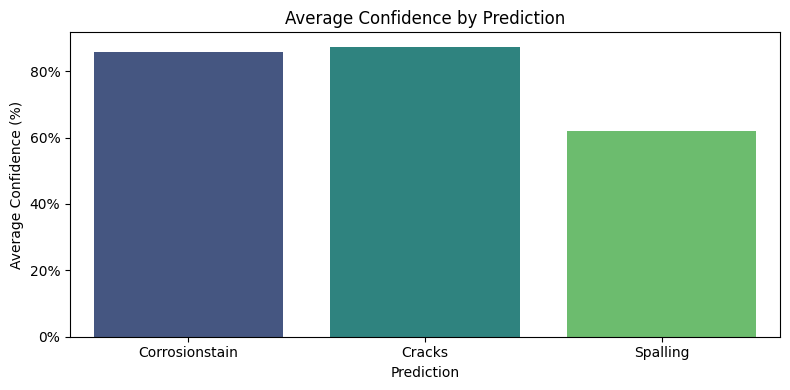

In [35]:
plot_average_confidence(eval_df)

### Check the average prediction accuracy

In [36]:
def plot_accuracy_per_class(eval_df):
    """
    Plots the accuracy per class for each damage type.
    Parameters:
    - eval_df: DataFrame containing evaluation results.
    
    Returns:
    - None (displays the plot)
    """
    # Calculate accuracy per class
    accuracy_per_class = eval_df.groupby('Damage Type').apply(
        lambda x: (x['Prediction'] == x['Damage Type']).mean()
    ).reset_index()
    
    accuracy_per_class.columns = ['Damage Type', 'Accuracy']
    
    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Damage Type', y='Accuracy', data=accuracy_per_class, palette='viridis')
    
    plt.title('Accuracy per Damage Type')
    plt.xlabel('Damage Type')
    plt.ylabel('Accuracy (%)')
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_29763/2858622185.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_class = eval_df.groupby('Damage Type').apply(
/tmp/ipykernel_29763/2858622185.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Damage Type', y='Accuracy', data=accuracy_per_class, palette='viridis')


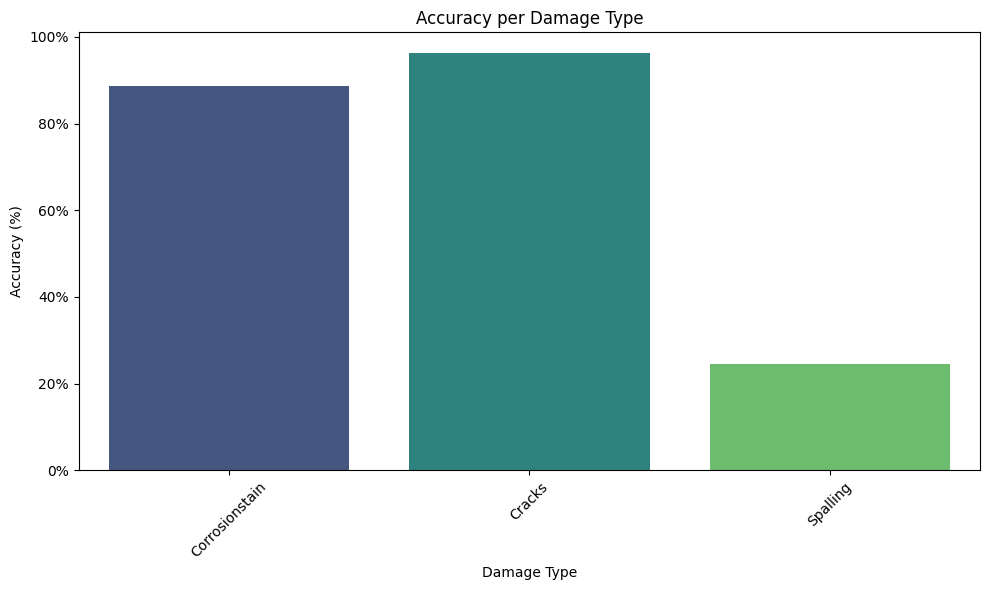

In [37]:
plot_accuracy_per_class(eval_df)

The accuracy turned to normal, but spalling's is still low.

### Confusion matrix

In [38]:
def plot_class_correlation(y_true, y_pred, class_names):
    """
    Plots a confusion matrix for the given true and predicted labels.
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - class_names: List of class names
    
    Returns:
    - None (displays the plot)
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title('Confusion Matrix\n')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

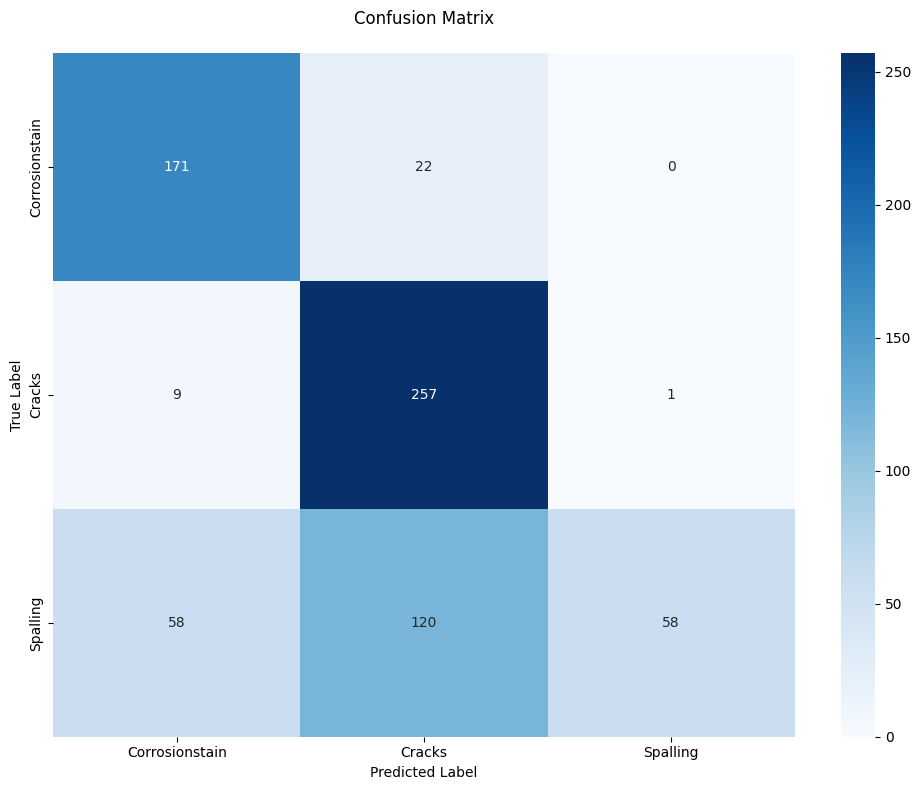

In [39]:
plot_class_correlation(eval_df['Damage Type'], eval_df['Prediction'], eval_df['Damage Type'].unique())

Spalling is more likely to be misclassified as other classes, especially as cracks.